<a href="https://colab.research.google.com/github/Praveen3ravi/Machine_Learning/blob/main/Regression_%26_XGBoost_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# from google.colab import files
# files.upload()

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from scipy.stats import skew
from collections import OrderedDict
import seaborn as sns
%matplotlib inline

In [6]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [7]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
isnull_ = pd.DataFrame(train_df.isnull().sum())
is_null = isnull_.T
is_null

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0


In [9]:
train_df = pd.DataFrame(train_df)

In [10]:
train_df.dropna(axis=1,thresh=1000,inplace=True)

In [11]:
pd.DataFrame(train_df.isnull().sum()).T

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,0,0,259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,81,81,0,0,81,81,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
print(train_df.columns[train_df.isnull().any()])
print("These many columns have null values between 1 to 459:",len(train_df.columns[train_df.isnull().any()]))

Index(['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond'],
      dtype='object')
These many columns have null values between 1 to 459: 14


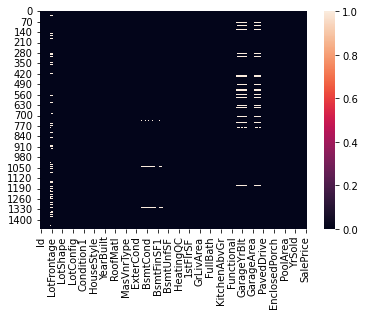

In [13]:
sns.heatmap(train_df.isnull())

In [14]:
null_list = ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond']
for i in null_list:
  print([i,train_df[i].dtypes])

['LotFrontage', dtype('float64')]
['MasVnrType', dtype('O')]
['MasVnrArea', dtype('float64')]
['BsmtQual', dtype('O')]
['BsmtCond', dtype('O')]
['BsmtExposure', dtype('O')]
['BsmtFinType1', dtype('O')]
['BsmtFinType2', dtype('O')]
['Electrical', dtype('O')]
['GarageType', dtype('O')]
['GarageYrBlt', dtype('float64')]
['GarageFinish', dtype('O')]
['GarageQual', dtype('O')]
['GarageCond', dtype('O')]


In [15]:
train_df['LotFrontage'].fillna(value=train_df['LotFrontage'].mean(),inplace=True)
train_df['MasVnrArea'].fillna(value=train_df['MasVnrArea'].mean(),inplace=True)     
train_df['GarageYrBlt'].fillna(value=train_df['GarageYrBlt'].mean(),inplace=True)                 

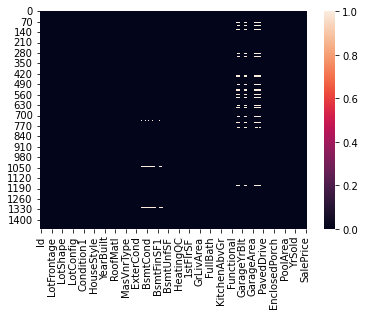

In [16]:
sns.heatmap(train_df.isnull())

In [17]:
train_df.columns[train_df.isnull().any()]

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [18]:
train_df.drop('MasVnrType',axis=1,inplace=True)

In [19]:
train_df.columns[train_df.isnull().any()]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [20]:
train_df.columns[train_df.isnull().any()]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'],
      dtype='object')

In [21]:
train_df.fillna(method="bfill",inplace=True)

In [22]:
train_df.columns[train_df.isnull().any()]

Index([], dtype='object')

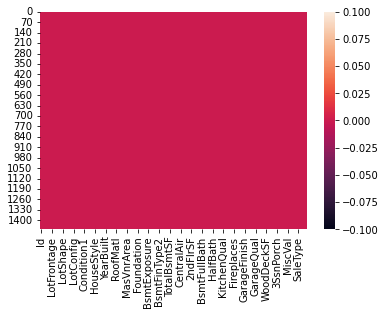

In [23]:
sns.heatmap(train_df.isnull())

In [24]:
train_df.dtypes.value_counts()

object     37
int64      35
float64     3
dtype: int64

In [25]:
train_df.drop('Id',axis=1,inplace=True)

In [26]:
pd.DataFrame(train_df.dtypes.value_counts()).T

,object,int64,float64
0,37,34,3


In [27]:
non_numerics = [x for x in train_df.columns \
                if not (train_df[x].dtype == np.float64 \
                        or train_df[x].dtype == np.int64)]
print(non_numerics)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
encoded = pd.get_dummies(train_df,columns=non_numerics)
print(encoded)

      MSSubClass  LotFrontage  ...  SaleCondition_Normal  SaleCondition_Partial
0             60         65.0  ...                     1                      0
1             20         80.0  ...                     1                      0
2             60         68.0  ...                     1                      0
3             70         60.0  ...                     0                      0
4             60         84.0  ...                     1                      0
...          ...          ...  ...                   ...                    ...
1455          60         62.0  ...                     1                      0
1456          20         85.0  ...                     1                      0
1457          70         66.0  ...                     1                      0
1458          20         68.0  ...                     1                      0
1459          20         75.0  ...                     1                      0

[1460 rows x 267 columns]


In [30]:
train_df = pd.concat([train_df,encoded],axis=1)

In [31]:
train_df.drop(columns=non_numerics,axis=1,inplace=True)

In [32]:
train_df = train_df.T.drop_duplicates().T

In [33]:
train_df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

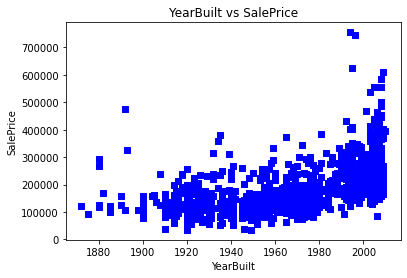

In [34]:
# YearBuilt
plt.scatter(train_df['YearBuilt'], train_df['SalePrice'], c = "blue", marker = "s")
plt.title("YearBuilt vs SalePrice")
plt.xlabel("YearBuilt")
plt.ylabel("SalePrice")
plt.show()

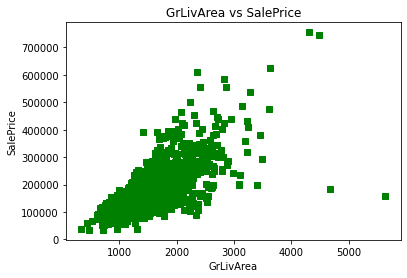

In [35]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], c = "green", marker = "s")
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

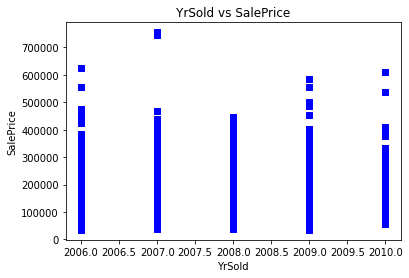

In [36]:
# YrSold
plt.scatter(train_df['YrSold'], train_df['SalePrice'], c = "blue", marker = "s")
plt.title("YrSold vs SalePrice")
plt.xlabel("YrSold")
plt.ylabel("SalePrice")
plt.show()

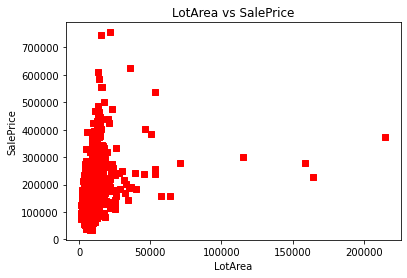

In [37]:
plt.scatter(train_df['LotArea'], train_df['SalePrice'], c = "red", marker = "s")
plt.title("LotArea vs SalePrice")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.show()

In [38]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

In [39]:
len(train_df.columns)

266

In [40]:
train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,...,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,8.0,0.0,2003.0,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,6.0,1.0,1976.0,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,6.0,1.0,2001.0,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,7.0,1.0,1998.0,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,9.0,1.0,2000.0,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
from sklearn.model_selection import train_test_split
X=train_df.drop('SalePrice',axis=1)
y=train_df['SalePrice']

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1095, 265), (365, 265), (1095,), (365,))

In [43]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [44]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()

In [46]:
model.fit(X_train_scaled,y_train)

LinearRegression()

In [47]:
y_pred=model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [48]:
tiktok=pd.DataFrame({'Actual':[y_test],'Model_Prediction':[y_pred]})
tiktok

,Actual,Model_Prediction
0,258 231500.0 267 179500.0 288 1220...,"[-6.344894034969925e+19, -1.2773247850253604e+..."


In [49]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [50]:
print(r2_score(y_test,y_pred))
print(mean_squared_error(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))

-5.6853122915152796e+29
3.816679788204301e+39
5.84825185064255e+19


In [51]:
import xgboost as xg
model_2=xg.XGBRegressor()

In [52]:
model_2= xg.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [53]:
model_2.fit(X_train_scaled,y_train)
# OrderedDict(sorted(model_2.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

[06:49:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4, learning_rate=0.07, min_child_weight=1.5,
             n_estimators=10000, reg_alpha=0.75, reg_lambda=0.45, seed=42,
             subsample=0.6)

In [54]:
# test_dataset['Prediction'] = np.expm1(model_2.predict(test_dataset[most_relevant_features]))
# filename = 'submission.csv'
# pd.DataFrame({'Id': test_dataset.Id, 'SalePrice': test_dataset.Prediction}).to_csv(filename, index=False)

In [55]:
y_pred2=model_2.predict(X_test_scaled)

In [56]:
print("XGBoost model Rsquared metric:",r2_score(y_test,y_pred2))
print("Linear Regression model Rsquared metric:",r2_score(y_test,y_pred))

XGBoost model Rsquared metric: 0.9247192744811307
Linear Regression model Rsquared metric: -5.6853122915152796e+29
